# Exercises Week 12: Bayesian Network and Causal Inference 

### Learning Goals:

After completing this lab exercise, you should be able to:

- verify Backdoor criterion to a Causal Bayesian Network
- analyze a Bayesian Network that exhibits Simpson's Paradox. 

**Note:** Tasks 1 and 2 can be solved with `pgmpy`.

This assignment consists of 2 tasks.

## Task 1 - Backdoor Criterion - Causal Games

Please go through all 5 games of the notebook `Backdoor Criterion - Causal Gamees.ipynb`, decide for each game whether the Backdoor criterion is fullfilled. Explain in detail the reasons. Verify your answer with the result of the pgmpy code.

## Task 2 - Simpson's paradox

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference

### Model Definition

In this exercise, you will analyze a Bayesian Network that exhibits Simpson's Paradox. The paradox occurs when a trend present in several groups reverses when the data is aggregated.

The provided Bayesian Network models three variables:
- \( S \): Gender (`m` or `f`)
- \( T \): Treatment (`0` or `1`)
- \( C \): Recovery (`0` or `1`)

The relationships are defined as:
- $ S \rightarrow T \rightarrow C$
- $ S \rightarrow C $

### Given Code

Below is the code to construct and analyze the Bayesian Network:


INFO:matplotlib.font_manager:generated new fontManager


<Axes: >

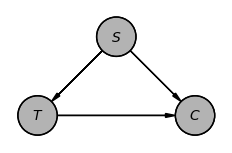

In [3]:
!pip install daft
simp_model = BayesianNetwork([("S", "T"), ("T", "C"), ("S", "C")])
simp_model.to_daft(node_pos={"T": (0, 0), "C": (2, 0), "S": (1, 1)}).render()

In [4]:
cpd_s = TabularCPD(
    variable="S", variable_card=2, values=[[0.5], [0.5]], state_names={"S": ["m", "f"]}
)
cpd_t = TabularCPD(
    variable="T",
    variable_card=2,
    values=[[0.25, 0.75], [0.75, 0.25]],
    evidence=["S"],
    evidence_card=[2],
    state_names={"S": ["m", "f"], "T": [0, 1]},
)
cpd_c = TabularCPD(
    variable="C",
    variable_card=2,
    values=[[0.3, 0.4, 0.7, 0.8], [0.7, 0.6, 0.3, 0.2]],
    evidence=["S", "T"],
    evidence_card=[2, 2],
    state_names={"S": ["m", "f"], "T": [0, 1], "C": [0, 1]},
)

simp_model.add_cpds(cpd_s, cpd_t, cpd_c)

### Inference conditioning on T

In [5]:
# Non adjusted inference
infer_non_adjust = VariableElimination(simp_model)
print(infer_non_adjust.query(variables=["C"], evidence={"T": 1}))
print(infer_non_adjust.query(variables=["C"], evidence={"T": 0}))

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5000 |
+------+----------+
| C(1) |   0.5000 |
+------+----------+
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.6000 |
+------+----------+
| C(1) |   0.4000 |
+------+----------+


### Inference with do-operation on T

In [6]:
infer_adjusted = CausalInference(simp_model)
print(infer_adjusted.query(variables=["C"], do={"T": 1}))
print(infer_adjusted.query(variables=["C"], do={"T": 0}))

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.6000 |
+------+----------+
| C(1) |   0.4000 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5000 |
+------+----------+
| C(1) |   0.5000 |
+------+----------+




**Task 1. Causal Graph**
(a) Draw the causal graph represented by the code.  
(b) Explain the relationships between variables \( S \), \( T \), and \( C \) in the context of the model.

**Task 2. Unadjusted Probability:**
Run the code provided to compute \( P(C | T = 1) \). What does this probability represent? How does it account for the influence of \( S \)?

**Task 3. Interventional Probability:**
Using the "do" operator, compute \( P(C | do(T = 1)) \). Explain how this result differs from the unadjusted probability and why it avoids Simpson's Paradox.

**Task 4. Interpretation:**
(a) Compare and interpret the results of \( P(C | T = 1) \) and \( P(C | do(T = 1)) \).  
(b) Discuss the importance of causal inference techniques in resolving paradoxes like Simpson's.

## Specifying adjustment sets

<Axes: >

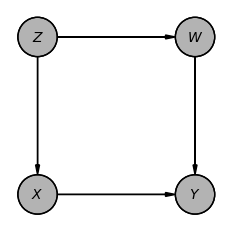

In [7]:
model = BayesianNetwork([("X", "Y"), ("Z", "X"), ("Z", "W"), ("W", "Y")])
cpd_z = TabularCPD(variable="Z", variable_card=2, values=[[0.2], [0.8]])

cpd_x = TabularCPD(
    variable="X",
    variable_card=2,
    values=[[0.1, 0.3], [0.9, 0.7]],
    evidence=["Z"],
    evidence_card=[2],
)

cpd_w = TabularCPD(
    variable="W",
    variable_card=2,
    values=[[0.2, 0.9], [0.8, 0.1]],
    evidence=["Z"],
    evidence_card=[2],
)

cpd_y = TabularCPD(
    variable="Y",
    variable_card=2,
    values=[[0.3, 0.4, 0.7, 0.8], [0.7, 0.6, 0.3, 0.2]],
    evidence=["X", "W"],
    evidence_card=[2, 2],
)

model.add_cpds(cpd_z, cpd_x, cpd_w, cpd_y)

model.to_daft(node_pos={"X": (0, 0), "Y": (2, 0), "Z": (0, 2), "W": (2, 2)}).render()

In [8]:
# Do operation with a specified adjustment set.
infer = CausalInference(model)
do_X_W = infer.query(["Y"], do={"X": 1}, adjustment_set=["W"])
print(do_X_W)

do_X_Z = infer.query(["Y"], do={"X": 1}, adjustment_set=["Z"])
print(do_X_Z)

do_X_WZ = infer.query(["Y"], do={"X": 1}, adjustment_set=["W", "Z"])
print(do_X_WZ)

infer_simp = CausalInference(simp_model)
do_simpson = infer_simp.query(["C"], do={"T": 1}, adjustment_set=["S"])
print(do_simpson)

  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


  0%|          | 0/4 [00:00<?, ?it/s]

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.7240 |
+------+----------+
| Y(1) |   0.2760 |
+------+----------+


  0%|          | 0/2 [00:00<?, ?it/s]

+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.6000 |
+------+----------+
| C(1) |   0.4000 |
+------+----------+


In [9]:
# Adjustment without do operation.
infer = CausalInference(model)
adj_W = infer.query(["Y"], adjustment_set=["W"])
print(adj_W)

adj_Z = infer.query(["Y"], adjustment_set=["Z"])
print(adj_Z)

adj_WZ = infer.query(["Y"], adjustment_set=["W", "Z"])
print(adj_WZ)

infer_simp = CausalInference(simp_model)
adj_simpson = infer_simp.query(["C"], adjustment_set=["S"])
print(adj_simpson)

+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6200 |
+------+----------+
| Y(1) |   0.3800 |
+------+----------+
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6200 |
+------+----------+
| Y(1) |   0.3800 |
+------+----------+
+------+----------+
| Y    |   phi(Y) |
+======+==========+
| Y(0) |   0.6200 |
+------+----------+
| Y(1) |   0.3800 |
+------+----------+
+------+----------+
| C    |   phi(C) |
+======+==========+
| C(0) |   0.5500 |
+------+----------+
| C(1) |   0.4500 |
+------+----------+
